### Calculate scoring rate + the probability distribution of time elapsed between scoring events

* work with one game first

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
sample = pd.read_csv (r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\pbp_games\g201410290PHO.csv")
sample.head (10)

,time,away_description,away_change,score,home_change,home_description
0,11:43.0,,,0-2,+2,M. Plumlee makes 2-pt dunk at rim (assist by E...
1,11:28.0,K. Bryant misses 2-pt jump shot from 16 ft,,0-2,,
2,11:26.0,Offensive rebound by Team,,0-2,,
3,11:25.0,,,0-2,,Violation by M. Plumlee (def goaltending)
4,11:25.0,C. Boozer makes 2-pt layup from 2 ft (assist b...,+2,2-2,,
5,11:03.0,,,2-5,+3,M. Morris makes 3-pt jump shot from 23 ft (ass...
6,10:51.0,J. Lin misses 2-pt jump shot from 19 ft,,2-5,,
7,10:49.0,Offensive rebound by J. Hill,,2-5,,
8,10:43.0,C. Boozer misses 2-pt jump shot from 15 ft,,2-5,,
9,10:41.0,,,2-5,,Defensive rebound by M. Plumlee


* ignore OTs

In [59]:
quarter = [0]*len(sample)
quarter [0] = 1
qt_count = 1

for i in range (1, len(sample)):
    secs_prev = int (sample['time'][i-1].split(":")[0])*60+float (sample['time'][i-1].split(":")[1])
    secs_cur = int (sample['time'][i].split(":")[0])*60+float (sample['time'][i].split(":")[1])
    if (secs_cur - secs_prev >= 60): # no way 60s is added back on the clock
        print (sample['time'][i-1], sample['time'][i])
        qt_count +=1 
    quarter [i] = qt_count

sample ['quarter'] = quarter

In [55]:
sample ['seconds'] = sample.apply (lambda x: x.quarter*12*60 - int(x.time.split(":")[0])*60
                                             - float(x.time.split(":")[1]), axis = 1)

In [56]:
sample.tail ()

,time,away_description,away_change,score,home_change,home_description,quarter,seconds
419,0:39.0,,,99-119,,Turnover by T. Ennis (lost ball; steal by R. P...,4,2841.0
420,0:35.0,R. Price misses 2-pt jump shot from 4 ft (bloc...,,99-119,,,4,2845.0
421,0:35.0,Offensive rebound by Team,,99-119,,,4,2845.0
422,0:24.0,R. Price misses 2-pt layup from 2 ft,,99-119,,,4,2856.0
423,0:22.0,,,99-119,,Defensive rebound by A. Tolliver,4,2858.0


In [37]:
score_dict = {} #key = seconds, value = points scored
for i in range (1, 2881):
    score_dict [i] = 0

In [38]:
for i in range (len(sample)):
    home_score = 0
    away_score = 0
    if (sample['home_change'][i][0] == "+"):
        home_score += int(sample['home_change'][i][1])
    if (sample['away_change'][i][0] == "+"):
        away_score += int(sample['away_change'][i][1])
    score_dict [sample['seconds'][i]] += home_score + away_score

NameError: name 'sample' is not defined

---

In [39]:
def time (sample):

    quarter = [0]*len(sample)
    quarter [0] = 1
    qt_count = 1

    for i in range (1, len(sample)):
        secs_prev = int (sample['time'][i-1].split(":")[0])*60+float (sample['time'][i-1].split(":")[1])
        secs_cur = int (sample['time'][i].split(":")[0])*60+float (sample['time'][i].split(":")[1])
        if (secs_cur - secs_prev >= 60): # no way 60s is added back on the clock
            # print (sample['time'][i-1], sample['time'][i])
            qt_count +=1 
        quarter [i] = qt_count
    sample ['quarter'] = quarter
    sample ['seconds'] = sample.apply (lambda x: x.quarter*12*60 - int(x.time.split(":")[0])*60
                                             - float(x.time.split(":")[1]), axis = 1)
    sample = sample [sample['quarter']<=4]
    return sample

In [40]:
score_dict = [0]*2881

In [41]:
def add_points (sample):

    for i in range (len(sample)):
        home_score = 0
        away_score = 0

        if (sample['home_change'][i][0] == "+"):
            home_score += int(sample['home_change'][i][1])
        if (sample['away_change'][i][0] == "+"):
            away_score += int(sample['away_change'][i][1])
            
        score_dict [int(sample['seconds'][i])] += home_score + away_score

In [42]:
games = pd.read_csv (r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\game_schedule.csv")

In [43]:
for i in range (len(games)):
    if (i%100 == 0):
        print (str(int(i/100))+"%")
    path = "g"+games['id'][i]+".csv"
    game = pd.read_csv (path)
    game = time (game)
    add_points (game)

0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
100%
101%


In [46]:
sec = []
for i in range (0, 2881):
    sec.append (i)

score = np.array(score_dict)/len(games)

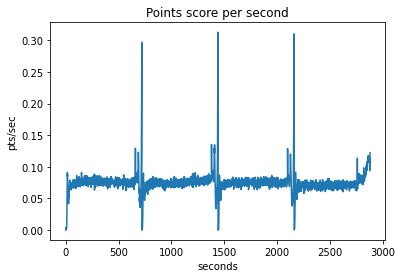

In [48]:
plt.title ("Points score per second")
plt.ylabel ("pts/sec")
plt.xlabel ("seconds")
plt.plot (sec, score)

In [49]:
print ("avg: ", np.mean(score))

avg:  0.07399778000600934


In [50]:
0.07399778000600934*2880

213.11360641730693